## Contextual Integration of NCAR/NOAA Environmental Data with the NOAA Water Column Sonar Archive

This notebook walks through an end-to-end workflow to relate shipboard sonar backscatter (Sv) to local environmental conditions. We (1) open EK60 data from a public NOAA S3 Zarr, (2) gather co-located environmental variables from OISST and IOOS ERDDAP, (3) compute hourly mean Sv, (4) assemble a depth×time error map for reference, and (5) synchronize timestamps to produce an interactive line-plus-heatmap visualization. All selections (time/depth/frequency) and conversions are kept explicit for reproducibility.

1. **Imports**
   Load core libraries for data access (xarray, s3fs), analysis (numpy, pandas), plotting (plotly), and I/O.

2. **Initializing the datasets**
   Access HB1906 EK60 Zarr data from public S3; subset by time/depth, select 38 kHz, and mask bins below bottom.

3. **Access buoy data**
   Define Georges Bank buoy coordinates, sample daily OISST SST at the nearest grid cell (±1 day), and download the model error map (`.npy`).

4. **Calculate the temperature anomaly, sun elevation in degree and azimuth**

5. **Downloading external error map for the specific location**
   Downloading the error map comes from a fixed file

6. **Helper Function: Mean Sv (dB)**
   Convert Sv from dB→linear, compute mean, convert back to dB.

7. **Group Cruise Data into Hourly Chunks**
   Add an hourly label and split the EK60 dataset into per-hour `xarray.Dataset` chunks.

8. **Compute Hourly Mean Sv & Attach to `env_df`**
   Aggregate Sv per hour and append results as a new column in the environmental dataframe.

9. **Build Depth×Time Error-Map DataFrame & Align Timestamps**
   Construct a depth-by-time matrix from the error map, guard for size mismatches, and align `env_df` endpoints to the heatmap timestamps.

10. **Data Visualization: Synchronized Lines + Heatmap**
   Plot environmental time series above a depth×time heatmap with shared x-axis; save interactive HTML output.


---

## Prerequisites
This section was inspired by [this template](https://github.com/alan-turing-institute/the-turing-way/blob/master/book/templates/chapter-template/chapter-landing-page.md) of the wonderful [The Turing Way](https://the-turing-way.netlify.app) Jupyter Book.

This notebook opens public NOAA EK60 Zarr data from S3, subsets by time/depth, reads daily OISST SST near a buoy, fetches ERDDAP environmental variables, computes hourly mean **Sv** (dB), aligns with a depth×time error map, and renders synchronized line/heatmap plots.

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance    | Notes                                                                 |
| --- |---------------|-----------------------------------------------------------------------|
| Xarray + Zarr basics | **Necessary** | Opening Zarr stores, selecting by coords/dims, `.compute()` semantics |
| s3fs & public S3 access | **Necessary** | Anonymous reads from AWS S3 (`anon=True`)                             |
| Pandas time series | **Necessary** | `DatetimeIndex`, sorting, filtering, timezone-naive vs. aware         |
| NumPy fundamentals | **Necessary** | Array slicing, stats, type conversion                                 |
| Acoustic backscatter (Sv) & dB averaging | **Necessary** | Convert dB→linear, mean, then linear→dB, Understanding results        |
| ERDDAP tabledap & info endpoints | **Helpful**   | Reading CSV responses; unit metadata lookup                           |
| Plotly fundamentals | **Helpful**   | Subplots, heatmaps, interactive HTML export                           |
| Understanding of NetCDF/CF | **Helpful**   | Variable metadata and geospatial conventions                          |
| Dask awareness | **Helpful**   | Lazy arrays; when/why to call `.compute()`                            |
| Geographic coordinates | **Helpful**   | 0–360 vs. −180–180 longitude handling                                 |
| HTTP/IO with `requests` | **Helpful**   | Downloading `.npy` assets for local use                               |

- **Time to learn**: ~75 minutes

- **System requirements**:
  - Python 3.9+ with Jupyter Notebook/Lab
  - Required packages: `xarray`, `s3fs`, `numpy`, `pandas`, `plotly`, `requests`, `netCDF4` *(optional but helpful: `dask`)*

**Note:** Run the cell below **only** in a local environment to install the required packages. If you’re using Binder, skip this step.

In [ ]:
import os
import sys
import yaml
import shutil
import subprocess

ENV_PATH = "../environment.yml"

with open(ENV_PATH, "r", encoding="utf-8") as f:
    env = yaml.safe_load(f)

channels = env.get("channels", [])
deps = env.get("dependencies", [])

conda_pkgs = []
pip_pkgs = []

for dep in deps:
    if isinstance(dep, str):
        # Skip python pin and the literal 'pip' meta-package entry
        name = dep.split("=")[0].strip().lower()
        if name in {"python", "pip"}:
            continue
        conda_pkgs.append(dep)
    elif isinstance(dep, dict) and "pip" in dep:
        pip_pkgs.extend(dep["pip"])

# Prefer mamba if present; fallback to conda
conda_exe = shutil.which("mamba") or shutil.which("conda")

# Install Conda packages
if conda_pkgs:
    if not conda_exe:
        raise RuntimeError("Conda/mamba not found in PATH. Run this inside a Conda environment.")
    # Install into the current environment prefix
    env_prefix = os.environ.get("CONDA_PREFIX", sys.prefix)
    cmd = [conda_exe, "install", "-y", "-p", env_prefix]
    for ch in channels:
        cmd += ["-c", ch]
    cmd += conda_pkgs
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)
else:
    print("No Conda packages to install.")

# Install pip packages into the current kernel's Python
if pip_pkgs:
    cmd = [sys.executable, "-m", "pip", "install", *pip_pkgs]
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)
else:
    print("No pip packages to install.")


---

## 1) Imports
Core libraries used throughout the notebook.

Key roles:

    xarray/s3fs for reading NOAA Zarr data from S3
    numpy/pandas for arrays & tables
    plotly for interactive plotting
    requests/io/os for file I/O and downloads
    datetime for time calculations

In [ ]:
import xarray as xr
import s3fs
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import requests
import io
import os
import rioxarray
from datetime import datetime, timedelta
import pvlib

## 2) Initializing the datasets

Builds the S3 path to the HB1906 EK60 Zarr dataset and opens it anonymously.
Subsets by time window and depth range, selects the 38 kHz channel, and masks samples below the estimated bottom.
.compute() materializes the selection; hm_timestamps will be reused for time alignment later. All datasets are accessed
using the OSDF infrastructure

In [ ]:
bucket_name = 'noaa-wcsd-zarr-pds'
ship_name = "Henry_B._Bigelow"
cruise_name = "HB1906"
sensor_name = "EK60"

# Accessing the NOAA HB1906 dataset using OSDF (anonymous S3)
s3_file_system = s3fs.S3FileSystem(anon=True)
zarr_store = f'{cruise_name}.zarr'
s3_zarr_store_path = f"{bucket_name}/level_2/{ship_name}/{cruise_name}/{sensor_name}/{zarr_store}"

# Map S3 path to a zarr store and open (consolidated=None to let xarray infer metadata)
store = s3fs.S3Map(root=s3_zarr_store_path, s3=s3_file_system, check=False)
cruise = xr.open_zarr(store=store, consolidated=None)

# Time/depth subset and single-frequency selection
start_time = "2019-10-16T15:00:00"
end_time = "2019-10-16T23:11:09"
timeslice = slice(start_time, end_time)
depths = slice(10, 250)
cruise = cruise.sel(time=timeslice, depth=depths, drop=False)
cruise = cruise.sel(frequency=38000, method='nearest').compute()  # materialize after selection
cruise = cruise.where(cruise.depth < cruise.bottom + 2, drop=True)  # remove bins below bottom

# Timestamps for later alignment
hm_timestamps = cruise.time.values.tolist()

## 3) Accessing buoy data
Defines a buoy location on Georges Bank (longitude converted to 0–360).
1) Optional: Loads three daily OISST files and samples SST at the nearest grid point (day before, day of, day after).
2) ERDDAP buoy environmental data.

Sets ERDDAP dataset parameters and enforces a max_days cap by adjusting end_date_time if needed.
Reads station metadata to extract lon/lat and wind-speed units; prepares a conversion to knots.
Pulls a table of time, wind_speed, SST, significant wave height, converts wind speed to knots, indexes by time.
Filters to the requested window and keeps the first nine rows (intentional truncation for later alignment).

In [ ]:
# Location of one specific buoy located on Georges Bank
target_lon = 360 - 66.546  # convert from -180..180 to 0..360
target_lat = 41.088

# ______________OPTIONAL BUOY DATA FROM NCAR/UCAR______________
# print(f"Target coordinates: Longitude: {target_lon}, Latitude: {target_lat}")
#
# # Accessing stationary buoy data (daily OISST files); select nearest grid cell
# buoy_data_day_before = xr.open_dataset(
#     'https://data.rda.ucar.edu/d277007/avhrr_v2.1/2019/oisst-avhrr-v02r01.20191015.nc#mode=bytes', engine='netcdf4')
# buoy_data_actual_day = xr.open_dataset(
#     'https://data.rda.ucar.edu/d277007/avhrr_v2.1/2019/oisst-avhrr-v02r01.20191016.nc#mode=bytes',
#     engine='netcdf4')
# buoy_data_day_after = xr.open_dataset(
#     'https://data.rda.ucar.edu/d277007/avhrr_v2.1/2019/oisst-avhrr-v02r01.20191017.nc#mode=bytes',
#     engine='netcdf4')
#
# sst_day_before = buoy_data_day_before['sst'].sel(lon=target_lon, lat=target_lat, method='nearest').values[0][0]
# sst_actual_day = buoy_data_actual_day['sst'].sel(lon=target_lon, lat=target_lat, method='nearest').values[0][0]
# sst_day_after = buoy_data_day_after['sst'].sel(lon=target_lon, lat=target_lat, method='nearest').values[0][0]
# ______________________________________________________________

# The following code has been copied from https://github.com/ioos/soundcoop/blob/main/3_HMD_environmental_data/plot_sound_environmental_and_climatology_data.ipynb in order to access buoy environmental data.

erddap_dataset = 'gov-ndbc-44005'
sound_dataset = 'Monh'
max_days = 25
start_date_time = '2019-10-16T14:00:00.000'
end_date_time = '2021-10-16T23:30:00.000'
min_frequency = 21
max_frequency = 24000

erddap_base_url = 'https://erddap.sensors.ioos.us/erddap'

# Cap the end date if requested range exceeds max_days
time_delta = datetime.fromisoformat(end_date_time) - datetime.fromisoformat(start_date_time)
if time_delta.days > max_days:
    end_date_time = str(datetime.fromisoformat(start_date_time) + timedelta(days=max_days))
    print(f'end_date_time updated to {end_date_time}')

# Get station lon/lat and units from ERDDAP metadata (CSV)
erddap_metadata_url = f'{erddap_base_url}/info/{erddap_dataset}/index.csv'
env_metadata_df = pd.read_csv(erddap_metadata_url)

env_station_x = env_metadata_df.loc[env_metadata_df['Attribute Name'] == 'geospatial_lon_min']['Value'].item()
env_station_y = env_metadata_df.loc[env_metadata_df['Attribute Name'] == 'geospatial_lat_min']['Value'].item()
swt_var = 'sea_surface_temperature'

# __________OPTIONAL: Add Wind__________
# Determine wind_speed units to convert to knots
# wind_speed_units_row = env_metadata_df[
#     (env_metadata_df['Row Type'] == 'attribute') &
#     (env_metadata_df['Attribute Name'] == 'units') &
#     # (env_metadata_df['Variable Name'] == 'wind_speed')
#     ]
# wind_speed_units = wind_speed_units_row.iloc[0]['Value']
# print(wind_speed_units)

# wind_speed_to_kts_factors = {
#     "m.s-1": 1.94384,
#     "mph": 0.86897423357831,
#     "kmh": 0.53995555554212126825,
#     "ft.s-1": 0.59248243198521155506
# }

# if wind_speed_units in wind_speed_to_kts_factors:
#     print("Success! Units can be converted from", wind_speed_units, 'to', 'kts')
# else:
#     print("Error! Wind speed cannot be converted from", wind_speed_units, 'to', 'kts')

# wind_var = 'wind_speed'
# wave_var = 'sea_surface_wave_significant_height'
# anomaly_var = 'swt_anomaly'
# wind_var_kts = 'wind_speed_kts'
# ________________________________________

# Build ERDDAP tabledap query URL
erddap_dataset_url = (
    f'{erddap_base_url}/tabledap/{erddap_dataset}.csv'
    f'?time,{swt_var}'
)

# Read dataset (skip the second row of units)
env_df = pd.read_csv(
    erddap_dataset_url,
    skiprows=[1]  # The second row (index 1) are the column units, which we don't need
)

# Format time, convert wind speed to knots, index by time
env_df['time'] = pd.to_datetime(env_df['time'])
# env_df['wind_speed_kts'] = env_df['wind_speed'].apply(lambda x: x * wind_speed_to_kts_factors[wind_speed_units])
# del env_df['wind_speed']
env_df = env_df.set_index('time').sort_index()

# Filter by requested time window and keep first 9 rows (drops the rest)
env_df = env_df[(env_df.index > start_date_time) & (env_df.index < end_date_time)]
env_df.drop(env_df.tail(-9).index, inplace=True)
# env_df

### 4) Calculate the temperature anomaly, sun elevation in degree and azimuth
Extracts World Ocean Atlas 2023 temperature data for a specific location and month and calculates temperature anomaly (optional), sun elevation in degree and azimuth (optional).

In [ ]:
def get_woa23_temp_at_xy(x, y, month, var='t_mn', depth=0):
    """
    Get 1-degree WOA 2023 temperature values for a given point and month.

    Args:
        x: A longitude value given in decimal degrees
        y: A latitude value given in decimal degrees
        month: The month asn integer from which to extract the value
        var (optional): The temperature variable to use. Defaults to the statistical mean.
        depth (optional): The depth at which to extract the value. Defaults to the surface.
    """
    url = (
        'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'
        f'temperature/netcdf/decav/1.00/woa23_decav_t{month:02}_01.nc'
    )
    ds = xr.open_dataset(
        url,
        decode_times=False  # xarray can't handle times defined as "months since ..."
    )

    da = ds.isel(depth=depth)[var]  # Pull out just the variable we're interested in

    # Because nearshore locations are often NaN due to the grid's low resolution
    # we need to interpolate the NaNs to the nearest non-NaN before extracting our value.
    # We use rioxarray to do the interpolations in two dimensions because plain vanilla xarray
    # can only interpolate in one dimension.
    da = da.rio.write_crs(4326)
    da = da.rio.interpolate_na(method='nearest')

    # Then we extract the value, also using the nearest neighbor method because the given
    # x and y values are unlikely to fall exactly on one of the grid's lat/lon coordinate pairs
    val = da.sel(lon=x, lat=y, method='nearest').item()

    return val


# Define the location of our selected ERDDAP dataset
# Override here if needed
x = env_station_x
y = env_station_y

url = (
    'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'
    f'temperature/netcdf/decav/1.00/woa23_decav_t07_01.nc'
)
da = xr.open_dataset(
    url,
    decode_times=False  # xarray can't handle times defined as "months since ..."
).isel(depth=0)['t_mn']  # Pull out just the variable we're interested in

# Because nearshore locations are often NaN due to the grid's low resolution
# we need to interpolate the NaNs to the nearest non-NaN before extracting our value.
# We use rioxarray to do the interpolations in two dimensions because plain vanilla xarray
# can only interpolate in one dimension.
da = da.rio.write_crs(4326)
da = da.rio.interpolate_na(method='nearest')

# Then we extract the value, also using the nearest neighbor method because the given
# x and y values are unlikely to fall exactly on one of the grid's lat/lon coordinate pairs
val = da.sel(lon=x, lat=y, method='nearest').item()

# Assemble a mapping between months and WOA 2023 temperature values
months = list(range(1, 13))
temps = [get_woa23_temp_at_xy(x, y, m) for m in months]
clim_dict = {m: t for m, t in zip(months, temps)}

# Calculate the sea water temperature anomaly by subtracting the monthly WOA 2023 temperature value
# from each measured sea water temperature value and store it as a new variable
anomaly_var = env_df[swt_var] - [clim_dict[10]]
# We are not adding the temperature_anomaly variable to our dataset, because we were able to see that it follows the sea surface temperature.
# env_df["temperature_anomaly"] = anomaly_var

# ---- Time range in UTC ----
times_utc = pd.date_range(
    start=start_date_time,
    end=end_date_time,
    freq="1h",
    tz="UTC"  # <-- key: set timezone to UTC
)

# ---- Calculate solar position ----
solpos = pvlib.solarposition.get_solarposition(times_utc, target_lat, target_lon)

# ---- Extract elevation ----
df = pd.DataFrame({
    "time_utc": times_utc,
    "elevation_deg": solpos["elevation"],
    "azimuth_deg": solpos["azimuth"]
})

env_df["elevation_deg"] = solpos["elevation"].tolist()[1:10]
# env_df["azimuth_deg"] = solpos["azimuth"].tolist()[:9]
env_df

## 5) Downloading external error map for the specific location.
Currently the error map comes from a fixed file; our plan is to switch to a dynamic AWS download that accepts location parameters.

In [ ]:
# Downloading anomaly detection model error map from NCAR via OSDF
response = requests.get('https://data-osdf.rda.ucar.edu/ncar/rda/pythia_2025/osdf-cookbook/mae_error_map.npy')
response.raise_for_status()
sonar_clusters = np.load(io.BytesIO(response.content))

---

## 6) Helper: mean Sv in dB
Computes the mean of Sv correctly by converting dB → linear, averaging, then linear → dB.
Accepts array-like input (NumPy/xarray/dask); returns a scalar in dB.

In [ ]:
def calculate_sv_mean(input_sv):
    # Convert dB to linear, mean in linear space, convert back to dB
    sv = 10. ** (input_sv / 10.)
    return 10 * np.log10(np.mean(sv))

## 7) Group cruise data into hourly chunks
Adds an hourly label and groups the cruise data by hour.
Produces a list of per-hour xarray.Dataset chunks for downstream aggregation.

In [ ]:
cruise['time_hour'] = cruise['time'].dt.floor('1h')  # hourly bin label

# Group by each hour
grouped = cruise.groupby('time_hour')

# Extract each 1-hour Dataset as a chunk (drop helper label)
chunks = [group.drop_vars('time_hour') for _, group in grouped]

## 8) Compute hourly mean Sv and attach to env_df
Iterates over hourly chunks, computes mean Sv per hour using calculate_sv_mean.
Converts dask→NumPy→Python float and appends to a list.
Assigns the resulting hourly series to env_df["sv_hourly"].
Assumes the number/order of hours matches rows retained in env_df.

In [ ]:
sv_hourly = []
timestamps = []

for i in range(0, len(chunks)):
    sv_data = chunks[i]['Sv']
    result = calculate_sv_mean(sv_data)

    # Use first time in hour as representative timestamp
    ts = pd.to_datetime(chunks[i]['time'].values[0])
    result = result.compute()  # dask -> numpy
    result = float(result.values)  # numpy -> Python float

    sv_hourly.append(result)

env_df["sv_hourly"] = sv_hourly

## 9) Build (depth × time) error-map DataFrame and align timestamps
Extracts one channel from sonar_clusters and pairs it with cruise depths and timestamps to form a DataFrame.
Uses min(...) to guard against size mismatches in depth/time dimensions.
Aligns only the first and last timestamps in env_df to the heatmap’s time range (keeps interior indices unchanged, sets UTC).

In [ ]:
# Prepare axes
depths = np.asarray(cruise.depth.values)
times = pd.to_datetime(hm_timestamps)

# Select channel/slice from sonar_clusters
vals = sonar_clusters[:, :, 1]  # (1088, 28096)

# Guard against mismatched sizes
n_depth = min(len(depths), vals.shape[0])
n_time = min(len(times), vals.shape[1])

# DataFrame: rows=depths, cols=timestamps
df = pd.DataFrame(
    data=vals[:n_depth, :n_time],
    index=depths[:n_depth],
    columns=times[:n_time]
)

# Align env_df index endpoints to heatmap timestamps (keeps interior unchanged)
idx = env_df.index.tolist()
df_timestamps = pd.to_datetime(df.columns).tz_localize(None)
idx[0] = pd.Timestamp(df_timestamps.values[0], tz='UTC').floor("s")
idx[-1] = pd.Timestamp(df_timestamps.values[-1], tz='UTC').floor("s")
env_df.index = idx

## 10) Data Visualization: Synchronized Lines + Heatmap

Plots synchronized data: top = time series from line_df; bottom = depth×time heatmap from heatmap_df.
Expects line_df to have a DatetimeIndex (timezone-naive or converted).
Depth axis is reversed (surface at top).
Saves an interactive HTML file to the parent directory (correlations.html) and shows the figure if show=True.

In [ ]:
def plot_synchronized_heatmaps_from_df(
        heatmap_df: pd.DataFrame,
        line_df: pd.DataFrame,
        colorscale: str = "Reds",
        show_markers: bool = False,
        show: bool = False,
):
    if not isinstance(line_df.index, pd.DatetimeIndex):
        raise TypeError("line_df must have a DatetimeIndex")
    line_df = line_df.copy()
    if line_df.index.tz is not None:
        line_df.index = line_df.index.tz_convert(None)

    depths = np.asarray(heatmap_df.index)
    heatmap_timestamps = pd.to_datetime(heatmap_df.columns)
    z = heatmap_df.to_numpy()

    n = len(line_df.columns)
    fig = make_subplots(
        rows=n + 1,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.02,
        row_heights=[0.1] * n + [0.7],  # n small rows + large heatmap row
    )

    mode = "lines+markers" if show_markers else "lines"

    # Define units for each variable
    units = {
        'sea_surface_temperature': '°C',
        'elevation_deg': 'degrees',
        'sv_hourly': 'dB'
    }

    for i, col in enumerate(line_df.columns, start=1):
        fig.add_trace(
            go.Scatter(x=line_df.index, y=line_df[col], name=str(col), mode=mode, showlegend=True),
            row=i, col=1
        )

        # Add units as y-axis titles
        unit = units.get(col, '')  # Default to empty string if variable not found
        fig.update_yaxes(
            title_text=unit,
            row=i, col=1
        )

        if i < len(line_df.columns):
            fig.update_xaxes(showticklabels=False, row=i, col=1)

    fig.add_trace(
        go.Heatmap(
            z=z, x=heatmap_timestamps, y=depths, colorscale=colorscale,
            zmin=np.nanmin(z), zmax=np.nanmax(z),
            hovertemplate="t=%{x}<br>depth=%{y}<br>value=%{z}<extra></extra>",
        ),
        row=n + 1, col=1
    )
    fig.update_yaxes(autorange="reversed", row=n + 1, col=1, title_text="Depth")

    fig.update_layout(
        margin=dict(l=40, r=40, t=60, b=40),  # Reduced left margin, increased top for legend
        hovermode="x unified",
        template="plotly_white",
        # height=10 * n + 500,  # scale height with number of signals
    )

    # Enhanced horizontal legend positioning
    fig.update_layout(
        legend=dict(
            orientation='h',
            x=0,
            y=1.02,
            xanchor='left',
            yanchor='bottom',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='rgba(0,0,0,0.1)',
            borderwidth=1
        )
    )

    save_path = os.path.join(os.path.dirname(os.getcwd()), "correlations.html")
    fig.write_html(save_path)
    print(f"Plot saved to: {save_path}")
    if show:
        fig.show()
    return fig
# Uncomment this line in order to create the plot.
# fig = plot_synchronized_heatmaps_from_df(heatmap_df=df, line_df=env_df)
# fig.show()

Because rendering the plot is computationally intensive and involves downloading approximately 1 GB of data, we present a static image of the result instead.

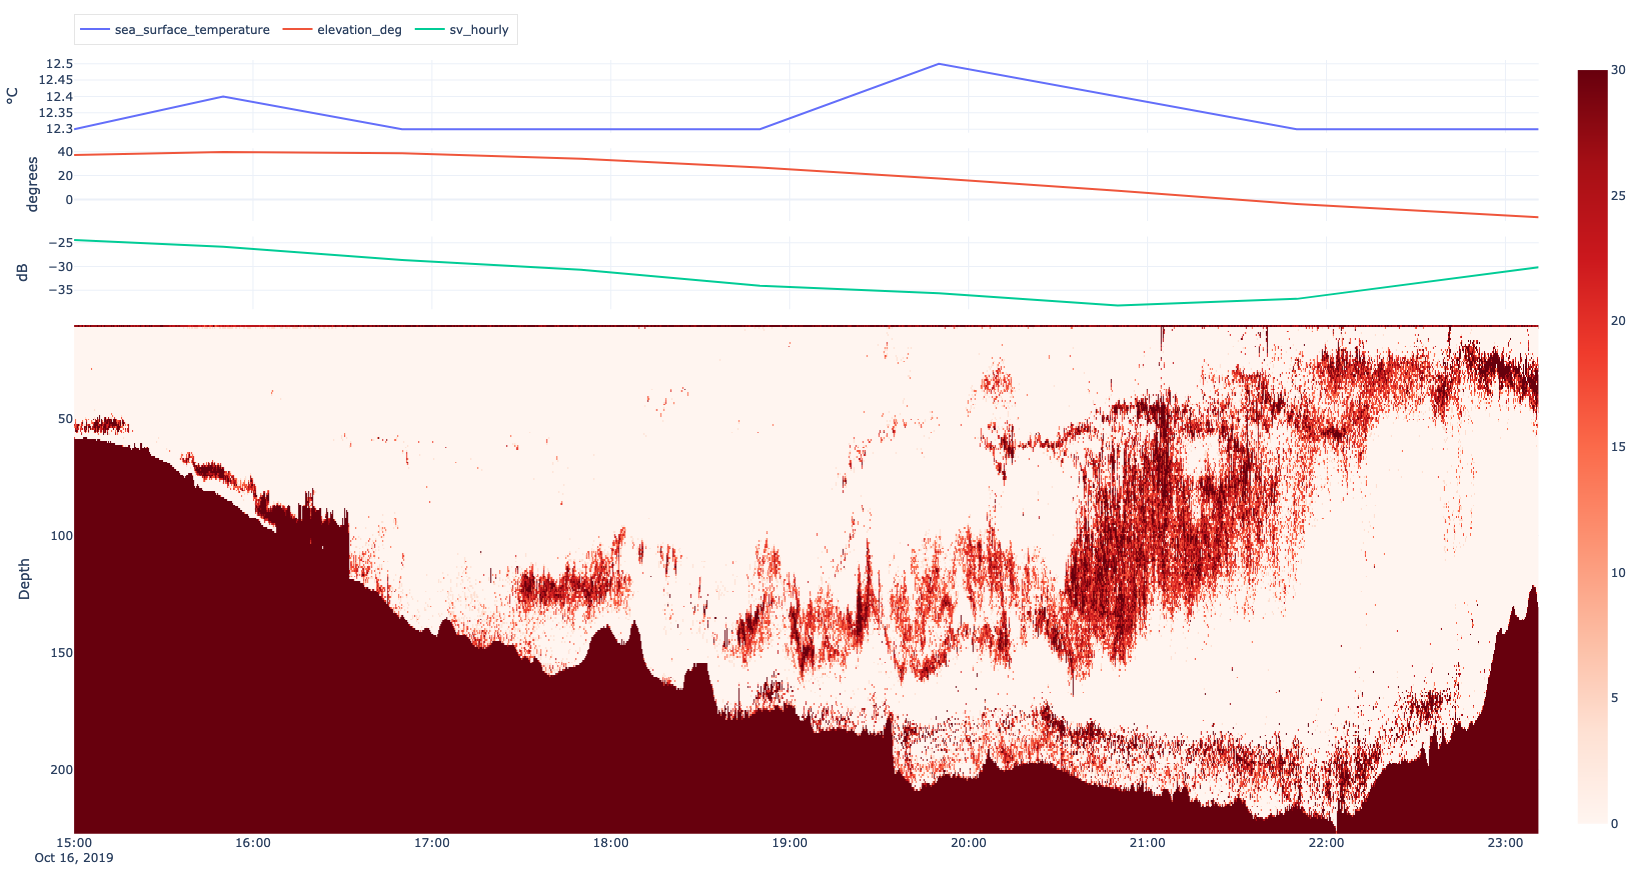

In [13]:
from IPython.display import Image, display
display(Image(filename='../images/sonarai_example.png'))